In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import re
import time
from sdv.tabular import GaussianCopula, CTGAN, CopulaGAN, TVAE
from sdv.constraints import Range
from sdv.constraints import ScalarRange
from sdv.constraints import Inequality
from sdv.constraints import ScalarInequality
from sdv.constraints import FixedCombinations

In [2]:
import os
os.chdir("/Users/santoshitadanki/Synthetic_Data_Generation_DS/data")
# os.chdir("/Users/santoshitadanki/Synthetic_Data_Generation_DS/data")

data = pd.read_csv('data_500k.csv')
print(data.shape)
display(data.head())
data.dtypes

(500000, 9)


,Date_of_birth,Opening_date,Expiry_date,Credit_limit,Statement_balance,Available_credit,city,province_name,postal
0,1907-02-05,2002-11-12,2007-11-12,39500.0,23047.49,16452.51,Toronto,Ontario,M3H
1,1953-12-10,2022-10-09,2027-10-09,13500.0,11144.41,2355.59,Yellowknife,Northwest Territories,X1A
2,1942-07-13,2005-12-13,2010-12-13,26000.0,17511.56,8488.44,Miltonvale Park,Prince Edward Island,C1E
3,1948-05-05,2018-02-13,2023-02-13,88500.0,11245.66,77254.34,Brampton,Ontario,L6P
4,1956-06-28,2009-03-20,2014-03-20,62000.0,27648.20,34351.80,Thames Centre,Ontario,N0L


Date_of_birth         object
Opening_date          object
Expiry_date           object
Credit_limit         float64
Statement_balance    float64
Available_credit     float64
city                  object
province_name         object
postal                object
dtype: object

In [7]:
class Detector():
    """
    A class to detect deterministic relationships between two/three columns from a given dataset.

    ...

    Attributes
    ----------
    data : Pandas DataFrame
        an input dataset in Pandas DataFrame format
        
    data_gen_count : int
        the number of rows to be
        
    threshold : float
        a cut-off percentage for detection functions to confirm the deterministic relationships
        
    inequality_dict : dictionary
        stores inequality deterministic relationships;
        in which the key is greater than its values
    
    ABC_dict : dictionary
        stores deterministic relationships like "A = B + C" among three colomns
    
    ABX_dict : dictionary
        stores deterministic relationships like "A = B + X" between two colomns
        
    hierarchy_dict : dictionary
        stores hierarchical relationships like 'province':'postal code' where province is the higher level 
        entity and postal code is a lower level entity such that postal code depends on the province value
        
    Methods
    -------
    preprocess():
        Change the dtpyes of date columns to float and 
        drop the rows of the input dataframe which have missing values.
    
    detect_inequality():
        Detect the inequality deterministic relationship between two colomns.
    
    detect_ABC():
        Detect the deterministic relationships like "A = B + C" among three colomns.
        
    detect_ABX():
        Detect the deterministic relationships like "A >= B + X" between two colomns.
        
    detect_hierarchy():
        Detect the deterministic relationship of hierarchy like "country > state > city" or "product > subproduct"
        
    create_constraints():
        Create constraints for synthetic data generation model training.
        
    model_create():
        Create a synthetic data model to generate n rows
    """
    def __init__(self, data, threshold, 
                 data_gen_count, syn_data,
                 inequality_dict={}, inequality_runtime=0,
                 ABC_dict={}, ABC_runtime=0, 
                 ABX_dict={}, ABX_runtime=0,
                 hierarchy_dict = {}, hierarchy_runtime=0,
                 constraints=[], modelfit_time=0, datagen_time=0
                ):
        """
        Constructs all the necessary attributes for the person object.

        Parameters
        ----------
            dataframe : Pandas DataFrame
                an input dataset in Pandas DataFrame format
                
            threshold : float
                a cut-off percentage for detection functions to confirm the deterministic relationships
                
            inequality_dict : dictionary
                an empty dictionary to store inequality deterministic relationships
    
            ABC_dict : dictionary
                an empty dictionary to store deterministic relationships among three columns like "A = B + C"
            
            ABX_dict : dictionary
                an empty dictionary to store deterministic relationships between two columnslike "A >= B + X"
            
            constarints : list
                an empty list to store contraints for synthetic data generation model training
        """    
        self.data = data
        self.threshold = threshold
        
        self.data_gen_count = data_gen_count
        self.syn_data = syn_data
        
        self.inequality_dict = inequality_dict
        self.inequality_runtime = inequality_runtime
        
        self.ABC_dict = ABC_dict
        self.ABC_runtime = ABC_runtime
        
        self.ABX_dict = ABX_dict 
        self.ABX_runtime = ABX_runtime
        
        self.hierarchy_dict = hierarchy_dict 
        self.hierarchy_runtime = hierarchy_runtime
        
        self.constraints = constraints
        
    def preprocess(self):
        """
        Change date columns to float format;
        Handle missing values of the input dataframe;
        Drop the rows with missing values.
        
        Returns:
            None.
        
        Output:
            Running finished message with execution time.
        """
        st = time.time()
        
        data = self.data
        
        ref_dt = pd.Timestamp('1900-01-01')

        str2date = lambda x: dt.strptime(x, "%Y-%m-%d") - ref_dt if x.replace(" ", "") else np.nan
        
        for col in data.columns:
            
            try:
                re.match('^[0-9]{4}\-[0-9]{2}\-[0-9]{2}$', data[col][0])
                
                self.data[col] = self.data[col].apply(str2date)
                self.data[col] = (self.data[col] / np.timedelta64(1, 'D')).astype(float)
                
            except:
                pass
            
        data.dropna(axis=0, inplace=True)
        self.data = data

        et = time.time()
        elapsed_time = et - st
        print("Date types reformatted and missing values handled successfully!\nExecution Time:"
              , round(elapsed_time, 4), "seconds")

    def detect_inequality(self):
        """
        Detect the inequality deterministic relationship between colomns;
        Update the inequality_dictionary of the class object.
        
        Returns:
            None.
        
        Output:
            Number of relationships detected with execution time.
        """
        st = time.time()
        
        data = self.data
        inequality_dict = {}
        
    # Looping through all combinitions of columns
        for i in range(len(data.columns)):
            for j in range(i+1, len(data.columns)):
                
                # Extract the column pairs in float format
                if (data[data.columns[i]].dtypes == 'float' and data[data.columns[j]].dtypes == 'float'):
                    diff = []
                    count = 0
                    for rownum, row in data.iterrows():
                        diff.append(row[i] - row[j])
                    for num in diff:
                        if num < 0:
                            count+=1 
                    if float(count)/len(diff) >= self.threshold:
                        if data.columns[j] in inequality_dict.keys():
                            inequality_dict[data.columns[j]].append(data.columns[i])
                        else:
                            inequality_dict[data.columns[j]] = []
                            inequality_dict[data.columns[j]].append(data.columns[i])
                    elif float(len(diff) - count)/len(diff) >= self.threshold:
                        if data.columns[i] in inequality_dict.keys():
                            inequality_dict[data.columns[i]].append(data.columns[j])
                        else:
                            inequality_dict[data.columns[i]] = []
                            inequality_dict[data.columns[i]].append(data.columns[j])
    
        self.inequality_dict = inequality_dict
        
        et = time.time()
        elapsed_time = et - st
        self.inequality_runtime = elapsed_time
        
        print(len(inequality_dict), "inequality relationships detected")
        print("Execution Time:", round(self.inequality_runtime, 4), "seconds")

    def detect_ABC(self):
        """
        Detect the deterministic relationships "A = B + C" among three columns;
        Based on the dictionary of inequality deterministic relationships.
        
        Returns:
            None.
        
        Output:
            Number of relationships detected with execution time.    
        """
        st = time.time()
        
        data = self.data
        ABC_dict = {}
        
        for key in self.inequality_dict:
            # Check if the len(the list of values of the key) is >= 2 
            if len(self.inequality_dict[key]) >= 2:
                for i in range(len(self.inequality_dict[key])):
                    for j in range(i+1, len(self.inequality_dict[key])):
                        count = 0
                        for index, row in data.iterrows():
                            if (row[key] == row[self.inequality_dict[key][i]] + row[self.inequality_dict[key][j]]):
                                count += 1
                        if float(count) / len(data.index) >= self.threshold:
                            if key in ABC_dict.keys():
                                ABC_dict[key].append([self.inequality_dict[key][i], self.inequality_dict[key][j]])
                            else:
                                ABC_dict[key] = []
                                ABC_dict[key].append([self.inequality_dict[key][i], self.inequality_dict[key][j]])
                 
        self.ABC_dict = ABC_dict
        
        et = time.time()
        elapsed_time = et - st
        self.ABC_runtime = elapsed_time
        
        print(len(ABC_dict), "ABC relationships detected")
        print("Execution Time:", round(self.ABC_runtime, 4), "seconds")
    
    def detect_ABX(self):
        """
        Detect the deterministic relationships "A >= B + X" between two columns;
        Based on the dictionary of inequality deterministic relationships.
        
        Returns:
            None.
        
        Output:
            Number of relationships detected with execution time. 
        """
        st = time.time()
        
        data = self.data
        ABX_dict = {}
        
        for key in self.inequality_dict:
            for value in self.inequality_dict[key]:
                diff = []
                for index, row in data.iterrows():
                    diff.append(row[key] - row[value])
                    
                if key in ABX_dict.keys():
                    ABX_dict[key].append([value, min(diff)])
                else:
                    ABX_dict[key] = []
                    ABX_dict[key].append([value, min(diff)])
        
        self.ABX_dict = ABX_dict
            
        et = time.time()
        elapsed_time = et - st
        self.ABX_runtime = elapsed_time
        
        print(len(ABX_dict), "ABX relationships detected")
        print("Execution Time:", round(self.ABX_runtime, 4), "seconds")
    
    def detect_hierarchy(self):
        """
        Detect the hierarchical deterministic relationship between two columns like "country > state > 
        Update the hierarchy_dict and hierarchy_runtime of the class object.
        
        Returns:
            None.
        
        Output:
            Number of relationships detected with execution time. 
            

        """
        st = time.time()
        
        data = self.data
        hierarchy_dict = {}
        
#         self.hierarchy_dict = hierarchy_dict 
#         self.hierarchy_runtime = hierarchy_runtime

        obj_cols = data.select_dtypes(include=['object'])

        singular_pairs= {}
        
#         self.threshold

        for col in obj_cols:

            col_minus = list(set(obj_cols)- set([col]))

            for col_req in col_minus:
                req_df = data.groupby(col).agg({col_req:'nunique'}).reset_index()
                if (data[data[col_req]==1].shape[0]>self.threshold*data.shape[0]):
#                 if (len(req_df[col_req].unique())==1 and req_df[col_req].unique()==[1] ):
                    print(col_req,':Singular Hierarchy Identified |',col)
                    if col_req in singular_pairs:
                        singular_pairs[col_req] = singular_pairs[col_req].append(col)
                    else:
                        singular_pairs[col_req] = list(col)

        # key - higher level Ex: Province
        # value - lower level Ex: Zip code
        self.hierarchy_dict = singular_pairs
        print(singular_pairs, len(singular_pairs))
        
        et = time.time()
        elapsed_time = et - st
        
        self.hierarchy_runtime = elapsed_time
        
        print(len(self.hierarchy_dict), "hierarchy relationships detected")
        print("Execution Time:", round(self.hierarchy_runtime, 4), "seconds")

    def create_constraints(self, inequality=False, ABC=False, ABX=False, hierarchy =True):
        """
        Create constraints for synthetic data generation model training.
        
        Parameters:
            inequality: bool, default=True
                If True, create constraints for inequality deterministic relationships.
            
            ABC: bool, default=True
                If True, create constraints for deterministic relationships like "A = B + C".
            
            ABC: bool, default=True
                If True, create constraints for deterministic relationships like "A = B + X".
        
        Returns:
            None.
        
        Output:
            Running finished message with execution time.
        """
        st = time.time()
        
        if inequality:
            for key in self.hierarchy_dict:
                for value in self.inequality_dict[key]:
                    self.constraints.append(Inequality(low_column_name=value, high_column_name=key))
        
#         if ABC:
#             for key in self.ABC_dict:
#                 for value_list in self.ABC_dict[key]:
#                     self.constrainsts.append()
        
#         if ABX:
#             for key in self.inequality_dict:
#                 for value_list in self.inequality_dict[key]:
#                     self.constrainsts.append()
        elif hierarchy:
            
            data = self.data
            
            # drop string fields that are not hierarchy columns 
            
            obj_cols = data.select_dtypes(include=['object'])
            
            hier_cols = hierarchy_dict.keys()
            
            col_minus = list(set(obj_cols)- set([hier_cols]))
            
            data = data.drop(columns= col_minus)
            
            self.data = data

            # create constrain 
            hierarchy_dict = self.hierarchy_dict
            for key in hierarchy_dict:
                self.constraints.append([FixedCombinations(column_names = [key,hierarchy_dict[key]])])
                    
                    

# constraints = [FixedCombinations(column_names = ['category','sub_category'])]

#         et = time.time()
#         elapsed_time = et - st
        
        
        
        print("Constrainsts created successfully!\nExecution Time:"
              , round(elapsed_time, 4), "seconds")
          
    def model_create(self, data_gen_count = 200 ,  gaussian_coupla=True, n = self.data):
            """
            Create synthetic data generation model & synthetic data.

            Parameters:
                gaussian_coupla: bool, default=True
                    If True, create gaussian_coupla model for synthetic data generation

                ABC: bool, default=True
                    If True, create constraints for deterministic relationships like "A = B + C".

                ABC: bool, default=True
                    If True, create constraints for deterministic relationships like "A = B + X".

            Returns:
                None.

            Output:
                Running finished message with execution time.
            """
            
            if data_gen_count == 200:
                data_gen_count = [int(self.data.shape[0]*0.1)> 200,int(self.data.shape[0]*0.1), 200]
            else:
                pass
            
            
            st = time.time()
            
            model = GaussianCopula(constraints=detector_obj.constraints)
            model.fit(self.data)

            et = time.time()
            self.modelfit_time = et - st

            st = time.time()
            
            new_data = model.sample(num_rows= data_gen_count)
            self.syn_data = new_data
            
            et = time.time()
            self.datagen_time = et - st
            
            print("Model created successfully!\nExecution Time:"
                  , round(self.modelfit_time, 4), "seconds")

            print("Model created successfully!\nExecution Time:", round(self.modelfit_time, 4), "seconds")


NameError: name 'self' is not defined

In [11]:
dc = {'a':[4], 'a': [5],'b':10}

type(dc['a'])
# dc

list

In [11]:
dict_a = {'a':[1,2],'b':[1,2]}

for key in dict_a.keys():
#     for lst in dict_a[key]
    print(dict_a[key])

[1, 2]
[1, 2]


In [ ]:
# data_select = data.sample(round(data.shape[0]*0.1),ignore_index=True)
# model_bm = pd.DataFrame(columns = ['data_rows',
#                                    'data_columns',
#                                    'constrain type',
#                                    'modelfit_time',
#                                    'datagen_time',
#                                    'rows_generated'])

for div in np.linspace(1, 0, num=20, endpoint=False)[::-1][14:]:
    
    print("*"*20)
    data_div = data_select.sample(round(data_select.shape[0]*round(div,2)),ignore_index=True)
    
    detector_obj = Detector(data_div, 0.95)
    
    detector_obj.detect_inequality()
    
    detector_obj.create_constraints()
    
    model = GaussianCopula(constraints=detector_obj.constraints)

    st = time.time()
    model.fit(detector_obj.data)
    et = time.time()
    modelfit_time = et - st
    
    st = time.time()
    new_data = model.sample(num_rows= round(data_div.shape[0]*0.1))
    et = time.time()
    datagen_time = et - st
    
    list_row = [data_div.shape[0], 
                data_div.shape[1],
                "Inequality",
                modelfit_time,
                datagen_time,
                round(data_div.shape[0]*0.1)
               ]
    
    model_bm.loc[len(model_bm)] = list_row
    

In [6]:
runtime_bm = pd.DataFrame(columns = ['inequality_runtime','ABC_runtime','ABX_runtime','hierarchy_runtime'])
runtime_bm['inequality_runtime'] = 5.0

data_div = data.sample(round(data.shape[0]*0.05),ignore_index=True)
    
detector_obj = Detector(data_div, 0.95)
detector_obj.detect_inequality()
# runtime_bm['inequality_runtime'] = detector_obj.inequality_runtime

detector_obj.detect_ABC()
# runtime_bm['ABC_runtime'] = detector_obj.ABC_runtime

detector_obj.detect_ABX()
# runtime_bm['ABX_runtime'] = detector_obj.ABX_runtime

detector_obj.detect_hierarchy()
# runtime_bm['hierarchy_runtime'] = detector_obj.hierarchy_runtime

list_row = [detector_obj.inequality_runtime,
            detector_obj.ABC_runtime,
            detector_obj.ABX_runtime,
            detector_obj.hierarchy_runtime
           ]
            
list_row = [round(float(n), 3) for n in list_row]

runtime_bm.loc[len(runtime_bm)] = list_row
runtime_bm

1 inequality relationships detected
Execution Time: 1.3217 seconds
1 ABC relationships detected
Execution Time: 0.5535 seconds
1 ABX relationships detected
Execution Time: 0.9909 seconds
{} 0
0 hierarchy relationships detected
Execution Time: 0.3522 seconds


,inequality_runtime,ABC_runtime,ABX_runtime,hierarchy_runtime
0,1.322,0.554,0.991,0.352


In [21]:
# data_select = data.sample(round(data.shape[0]*0.1),ignore_index=True)
# runtime_bm = pd.DataFrame(columns = ['data_shape','inequality_runtime','ABC_runtime','ABX_runtime'])

# for div in np.linspace(1, 0, num=20, endpoint=False)[::-1]:
    
#     print("*"*20)
#     data_div = data_select.sample(round(data_select.shape[0]*round(div,2)),ignore_index=True)
    
#     detector_obj = Detector(data_div, 0.95)
    
#     detector_obj.detect_inequality()
    
#     detector_obj.detect_ABC()
    
#     detector_obj.detect_ABX()
    
#     list_row = [data_div.shape, 
#                 round(detector_obj.inequality_runtime,4),
#                 round(detector_obj.ABC_runtime,4),
#                 round(detector_obj.ABX_runtime,4)
#                ]
    
#     runtime_bm.loc[len(runtime_bm)] = list_row
    

In [22]:
# np.linspace(1, 0, num=20, endpoint=False)

In [33]:
runtime_bm = pd.DataFrame(columns = ['data_shape',
                                     'inequality_runtime',
                                     'ABC_runtime',
                                     'ABX_runtime',
                                     'hierarchy_runtime'])
data_select = data.copy()

for div in np.linspace(1, 0, num=20, endpoint=False):
    
    print("*"*20)
    data_div = data_select.sample(round(data_select.shape[0]*round(div,2)),ignore_index=True)
    
    if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):
        pass
    else:
        detector_obj = Detector(data_div, 0.95)

        detector_obj.detect_inequality()

        detector_obj.detect_ABC()

        detector_obj.detect_ABX()

        detector_obj.detect_hierarchy()

        list_row = [data_div.shape, 
                    round(detector_obj.inequality_runtime,4),
                    round(detector_obj.ABC_runtime,4),
                    round(detector_obj.ABX_runtime,4),
                    round(detector_obj.hierarchy_runtime,4)
                   ]

        runtime_bm.loc[len(runtime_bm)] = list_row
    

********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 26.7542 seconds
1 ABC relationships detected
Execution Time: 11.228 seconds
1 ABX relationships detected
Execution Time: 20.2345 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 3.3402 seconds
********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 25.4942 seconds
1 ABC relationships detected
Execution Time: 10.7453 seconds
1 ABX relationships detected
Execution Time: 19.2192 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 3.2575 seconds
********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 24.031 seconds
1 ABC relationships detected
Execution Time: 10.1187 seconds
1 ABX relationships detected
Execution Time: 18.2594 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 3.0402 seconds
********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 22.7898 seconds
1 ABC relationships detected
Execution Time: 9.5511 seconds
1 ABX relationships detected
Execution Time: 17.7169 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 2.8694 seconds
********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 21.6285 seconds
1 ABC relationships detected
Execution Time: 9.9383 seconds
1 ABX relationships detected
Execution Time: 16.3287 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 2.7732 seconds
********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 20.2067 seconds
1 ABC relationships detected
Execution Time: 8.477 seconds
1 ABX relationships detected
Execution Time: 15.3383 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 2.6065 seconds
********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 18.8371 seconds
1 ABC relationships detected
Execution Time: 7.9508 seconds
1 ABX relationships detected
Execution Time: 14.237 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 2.3806 seconds
********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 17.5191 seconds
1 ABC relationships detected
Execution Time: 7.4327 seconds
1 ABX relationships detected
Execution Time: 13.2649 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 2.2461 seconds
********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 16.2355 seconds
1 ABC relationships detected
Execution Time: 6.7797 seconds
1 ABX relationships detected
Execution Time: 12.2449 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 2.0809 seconds
********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 14.8472 seconds
1 ABC relationships detected
Execution Time: 6.2258 seconds
1 ABX relationships detected
Execution Time: 11.1541 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 1.9443 seconds
********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 13.4333 seconds
1 ABC relationships detected
Execution Time: 5.6805 seconds
1 ABX relationships detected
Execution Time: 10.2035 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 1.7533 seconds
********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 12.112 seconds
1 ABC relationships detected
Execution Time: 5.1026 seconds
1 ABX relationships detected
Execution Time: 9.221 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 1.6009 seconds
********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 10.8218 seconds
1 ABC relationships detected
Execution Time: 4.5475 seconds
1 ABX relationships detected
Execution Time: 8.1805 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 1.4896 seconds
********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 9.4593 seconds
1 ABC relationships detected
Execution Time: 3.9766 seconds
1 ABX relationships detected
Execution Time: 7.2014 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 1.2886 seconds
********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 8.0928 seconds
1 ABC relationships detected
Execution Time: 3.4233 seconds
1 ABX relationships detected
Execution Time: 6.1237 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 1.1278 seconds
********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 6.7479 seconds
1 ABC relationships detected
Execution Time: 2.871 seconds
1 ABX relationships detected
Execution Time: 5.112 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.969 seconds
********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 5.4063 seconds
1 ABC relationships detected
Execution Time: 2.2871 seconds
1 ABX relationships detected
Execution Time: 4.0866 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.8114 seconds
********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 4.0526 seconds
1 ABC relationships detected
Execution Time: 1.714 seconds
1 ABX relationships detected
Execution Time: 3.0595 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.6501 seconds
********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 2.7227 seconds
1 ABC relationships detected
Execution Time: 1.1407 seconds
1 ABX relationships detected
Execution Time: 2.0285 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.4804 seconds
********************


/var/folders/dr/93vz6rpd21s8fyjsrx_ngyhm0000gn/T/ipykernel_97958/241991391.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if (runtime_bm['data_shape'].str.contains(str(data_div.shape)).any()):


1 inequality relationships detected
Execution Time: 1.3516 seconds
1 ABC relationships detected
Execution Time: 0.5657 seconds
1 ABX relationships detected
Execution Time: 1.0203 seconds
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.2913 seconds


In [34]:
path ="/Users/santoshitadanki/Synthetic_Data_Generation_DS/data/benchmark_results/" 
runtime_bm.to_csv(path+"detection_benchmark__03.23.01.csv",index=False)
runtime_bm

,data_shape,inequality_runtime,ABC_runtime,ABX_runtime,hierarchy_runtime
0,"(500000, 9)",26.7542,11.2280,20.2345,3.3402
1,"(475000, 9)",25.4942,10.7453,19.2192,3.2575
2,"(450000, 9)",24.0310,10.1187,18.2594,3.0402
3,"(425000, 9)",22.7898,9.5511,17.7169,2.8694
4,"(400000, 9)",21.6285,9.9383,16.3287,2.7732
5,"(375000, 9)",20.2067,8.4770,15.3383,2.6065
6,"(350000, 9)",18.8371,7.9508,14.2370,2.3806
7,"(325000, 9)",17.5191,7.4327,13.2649,2.2461
8,"(300000, 9)",16.2355,6.7797,12.2449,2.0809
9,"(275000, 9)",14.8472,6.2258,11.1541,1.9443


-----

In [42]:
# data_select = data.sample(round(data.shape[0]*0.1),ignore_index=True)
# model_bm = pd.DataFrame(columns = ['data_rows',
#                                    'data_columns',
#                                    'constrain type',
#                                    'modelfit_time',
#                                    'datagen_time',
#                                    'rows_generated'])

for div in np.linspace(1, 0, num=20, endpoint=False)[::-1][14:]:
    
    print("*"*20)
    data_div = data_select.sample(round(data_select.shape[0]*round(div,2)),ignore_index=True)
    
    detector_obj = Detector(data_div, 0.95)
    
    detector_obj.detect_inequality()
    
    detector_obj.create_constraints()
    
    model = GaussianCopula(constraints=detector_obj.constraints)

    st = time.time()
    model.fit(detector_obj.data)
    et = time.time()
    modelfit_time = et - st
    
    st = time.time()
    new_data = model.sample(num_rows= round(data_div.shape[0]*0.1))
    et = time.time()
    datagen_time = et - st
    
    list_row = [data_div.shape[0], 
                data_div.shape[1],
                "Inequality",
                modelfit_time,
                datagen_time,
                round(data_div.shape[0]*0.1)
               ]
    
    model_bm.loc[len(model_bm)] = list_row
    

********************
1 inequality relationships detected
Execution Time: 2.0146 seconds
Constrainsts created successfully!
Execution Time: 0.0002 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 3750/3750 [00:01<00:00, 3355.97it/s]


********************
1 inequality relationships detected
Execution Time: 2.1412 seconds
Constrainsts created successfully!
Execution Time: 0.0001 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 4000/4000 [00:01<00:00, 3316.58it/s]


********************
1 inequality relationships detected
Execution Time: 2.2634 seconds
Constrainsts created successfully!
Execution Time: 0.0001 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 4250/4250 [00:01<00:00, 2161.65it/s]


********************
1 inequality relationships detected
Execution Time: 2.4635 seconds
Constrainsts created successfully!
Execution Time: 0.0001 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 4500/4500 [00:01<00:00, 3179.19it/s]


********************
1 inequality relationships detected
Execution Time: 2.6982 seconds
Constrainsts created successfully!
Execution Time: 0.0001 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 4750/4750 [00:01<00:00, 2950.85it/s]


********************
1 inequality relationships detected
Execution Time: 2.7278 seconds
Constrainsts created successfully!
Execution Time: 0.0001 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 5000/5000 [00:02<00:00, 1949.67it/s]


In [40]:
np.linspace(1, 0, num=20, endpoint=False)[::-1][14:]*data_select.shape[0]

array([37500., 40000., 42500., 45000., 47500., 50000.])

In [43]:
# model_bm['rows_generated'] = model_bm['data_rows']*0.1
model_bm

,data_rows,data_columns,constrain type,modelfit_time,datagen_time,rows_generated
0,2500,9,Inequality,3.799258,0.146288,250.0
1,5000,9,Inequality,9.821057,0.093216,500.0
2,7500,9,Inequality,17.485027,0.137667,750.0
3,10000,9,Inequality,26.383524,0.163084,1000.0
4,12500,9,Inequality,36.348522,0.153681,1250.0
5,15000,9,Inequality,46.898354,0.304308,1500.0
6,17500,9,Inequality,57.757755,0.288293,1750.0
7,20000,9,Inequality,69.134437,0.349174,2000.0
8,22500,9,Inequality,80.839182,0.569524,2250.0
9,25000,9,Inequality,93.171111,0.629959,2500.0


In [50]:
data_select = data.sample(round(data.shape[0]*0.1),ignore_index=True)
# model_bm = pd.DataFrame(columns = ['data_rows',
#                                    'data_columns',
#                                    'constrain type',
#                                    'modelfit_time',
#                                    'datagen_time',
#                                    'rows_generated'])

for div in np.linspace(1, 0, num=20, endpoint=False)[::-1]:
    
    print("*"*20)
    data_div = data_select.sample(round(data_select.shape[0]*round(div,2)),ignore_index=True)
    
    detector_obj = Detector(data_div, 0.95)
    
    detector_obj.detect_hierarchy()
    
    detector_obj.create_constraints()
    
    model = GaussianCopula(constraints=detector_obj.constraints)

    st = time.time()
    model.fit(detector_obj.data)
    et = time.time()
    modelfit_time = et - st
    
    st = time.time()
    new_data = model.sample(num_rows= round(data_div.shape[0]*0.1))
    et = time.time()
    datagen_time = et - st
    
    list_row = [data_div.shape[0], 
                data_div.shape[1],
                "hierarchy",
                modelfit_time,
                datagen_time,
                round(data_div.shape[0]*0.1)
               ]
    
    model_bm.loc[len(model_bm)] = list_row
    

********************
Expiry_date :Singular Hierarchy Identified | Opening_date
Opening_date :Singular Hierarchy Identified | Expiry_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'Opening_date': 'Expiry_date', 'province_name': 'postal'} 3
3 hierarchy relationships detected
Execution Time: 0.069 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|████████████████████████| 250/250 [00:00<00:00, 1723.10it/s]
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject s

********************
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.0941 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|████████████████████████| 500/500 [00:00<00:00, 1658.91it/s]
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(


********************
Expiry_date :Singular Hierarchy Identified | Opening_date
Opening_date :Singular Hierarchy Identified | Expiry_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'Opening_date': 'Expiry_date', 'province_name': 'postal'} 3
3 hierarchy relationships detected
Execution Time: 0.1253 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|████████████████████████| 750/750 [00:00<00:00, 3724.45it/s]
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(


********************
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.1619 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 1000/1000 [00:00<00:00, 3789.61it/s]


********************
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.1842 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 1250/1250 [00:00<00:00, 2630.85it/s]


********************
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.2003 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 1500/1500 [00:00<00:00, 2576.73it/s]


********************
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.2235 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 1750/1750 [00:00<00:00, 3266.74it/s]


********************
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.259 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 2000/2000 [00:00<00:00, 2262.27it/s]


********************
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.2709 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 2250/2250 [00:01<00:00, 1822.49it/s]


********************
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.3108 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 2500/2500 [00:00<00:00, 2915.62it/s]


********************
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.3103 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 2750/2750 [00:01<00:00, 2317.74it/s]


********************
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.3314 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 3000/3000 [00:01<00:00, 2318.50it/s]


********************
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.3546 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 3250/3250 [00:01<00:00, 2914.28it/s]


********************
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.3748 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 3500/3500 [00:01<00:00, 2903.80it/s]


********************
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.3871 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 3750/3750 [00:01<00:00, 3017.95it/s]


********************
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.4121 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 4000/4000 [00:01<00:00, 3017.86it/s]


********************
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.4215 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 4250/4250 [00:01<00:00, 2402.03it/s]


********************
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.4414 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 4500/4500 [00:01<00:00, 2407.54it/s]


********************
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.4666 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 4750/4750 [00:01<00:00, 3046.80it/s]


********************
Expiry_date :Singular Hierarchy Identified | Opening_date
province_name :Singular Hierarchy Identified | postal
{'Expiry_date': 'Opening_date', 'province_name': 'postal'} 2
2 hierarchy relationships detected
Execution Time: 0.488 seconds
Constrainsts created successfully!
Execution Time: 0.0 seconds


/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/rdt/transformers/numerical.py:100: UserWarning: No rounding scheme detected for column 'Available_credit'. Data will not be rounded.
  warnings.warn(
/Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/sdv/metadata/table.py:457: UserWarning: Inequality cannot be transformed because columns: ['Credit_limit'] were not found. Using the reject sampling approach instead.
  warnings.warn(
Sampling rows: 100%|██████████████████████| 5000/5000 [00:02<00:00, 2295.87it/s]


In [51]:
# model_bm.at[20,'constrain type']='hierarchy'
model_bm

,data_rows,data_columns,constrain type,modelfit_time,datagen_time,rows_generated
0,2500,9,Inequality,3.799258,0.146288,250.0
1,5000,9,Inequality,9.821057,0.093216,500.0
2,7500,9,Inequality,17.485027,0.137667,750.0
3,10000,9,Inequality,26.383524,0.163084,1000.0
4,12500,9,Inequality,36.348522,0.153681,1250.0
5,15000,9,Inequality,46.898354,0.304308,1500.0
6,17500,9,Inequality,57.757755,0.288293,1750.0
7,20000,9,Inequality,69.134437,0.349174,2000.0
8,22500,9,Inequality,80.839182,0.569524,2250.0
9,25000,9,Inequality,93.171111,0.629959,2500.0


In [53]:
model_bm.columns


Index(['data_rows', 'data_columns', 'constrain type', 'modelfit_time',
       'datagen_time', 'rows_generated'],
      dtype='object')

In [46]:
np.linspace(1, 0, num=20, endpoint=False)[::-1][:1]

array([0.05])

In [ ]:
data_select = data.copy()

for div in np.linspace(1, 0, num=20, endpoint=False):
    
    print("*"*20)
    data_div = data_select.sample(round(data_select.shape[0]*round(div,2)),ignore_index=True)
    
    if (runtime_bm['data_shape']==data_div.shape):
        pass
    
    else:
        data_div = data_select.sample(round(data_select.shape[0]*round(div,2)),ignore_index=True)

        detector_obj = Detector(data_div, 0.95)

        detector_obj.detect_inequality()

        detector_obj.create_constraints()

        model = GaussianCopula(constraints=detector_obj.constraints)

        st = time.time()
        model.fit(detector_obj.data)
        et = time.time()
        modelfit_time = et - st

        st = time.time()
        new_data = model.sample(num_rows= round(data_div.shape[0]*0.1))
        et = time.time()
        datagen_time = et - st

        list_row = [data_div.shape[0], data_div.shape[1],
                    "Inequality",
                    modelfit_time,datagen_time
                   ]

        model_bm.loc[len(model_bm)] = list_row



Bad key text.latex.preview in file /Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.6.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.6.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/santoshitadanki/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       

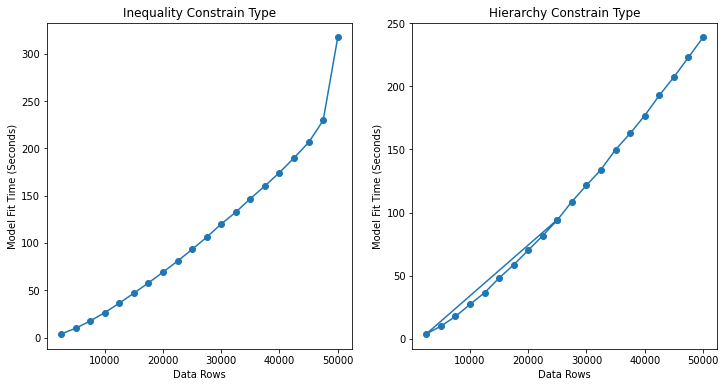

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# # Read the data from a CSV file
# df = pd.read_csv('data.csv')

# Filter the data based on the constrain type column
inequality_df = model_bm[model_bm['constrain type'] == 'Inequality']
hierarchy_df = model_bm[model_bm['constrain type'] == 'hierarchy']

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the model time for 'inequality' constrain type
ax1.plot(inequality_df['data_rows'], inequality_df['modelfit_time'], '-o')
ax1.set_xlabel('Data Rows')
ax1.set_ylabel('Model Fit Time (Seconds)')
ax1.set_title('Inequality Constrain Type')

# Plot the model time for 'hierarchy' constrain type
ax2.plot(hierarchy_df['data_rows'], hierarchy_df['modelfit_time'], '-o')
ax2.set_xlabel('Data Rows')
ax2.set_ylabel('Model Fit Time (Seconds)')
ax2.set_title('Hierarchy Constrain Type')

# Show the plot
plt.show()


In [52]:
path ="/Users/santoshitadanki/Synthetic_Data_Generation_DS/data/benchmark_results/" 
model_bm.to_csv(path+"model_benchmark_03.23.01.csv",index=False)
model_bm

,data_rows,data_columns,constrain type,modelfit_time,datagen_time,rows_generated
0,2500,9,Inequality,3.799258,0.146288,250.0
1,5000,9,Inequality,9.821057,0.093216,500.0
2,7500,9,Inequality,17.485027,0.137667,750.0
3,10000,9,Inequality,26.383524,0.163084,1000.0
4,12500,9,Inequality,36.348522,0.153681,1250.0
5,15000,9,Inequality,46.898354,0.304308,1500.0
6,17500,9,Inequality,57.757755,0.288293,1750.0
7,20000,9,Inequality,69.134437,0.349174,2000.0
8,22500,9,Inequality,80.839182,0.569524,2250.0
9,25000,9,Inequality,93.171111,0.629959,2500.0
